In [6]:
%load_ext autoreload
%autoreload 2


import sys
import os

from sklearn.linear_model import SGDClassifier, LinearRegression, Lasso, Ridge
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import seaborn as sn
import random
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.manifold import TSNE
import tqdm
import copy
from sklearn.svm import LinearSVC 

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import TruncatedSVD
import torch
from sklearn.linear_model import SGDClassifier
from rlace import solve_adv_game

from sklearn.svm import LinearSVC

import sklearn
from sklearn.linear_model import LogisticRegression
import random
import pickle
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import neural_network
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import warnings
import argparse
from sklearn.neural_network import MLPClassifier
from collections import defaultdict
import scipy
from scipy import stats
from scipy.stats import pearsonr
import pandas as pd
from rlace import init_classifier
from collections import Counter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
bios_data_path = "../WWW/rlace/bios/data/bios_data"
bios_encodings_path = "../WWW/rlace/bios/data/encodings/freezed"

data = []
for mode in ["train", "dev", "test"]:
    with open(bios_data_path + "/" + "{}.pickle".format(mode), "rb") as f:
        data.append(pickle.load(f))
        
train,dev,test = data
gender2ind = {"m": 0, "f": 1}
train_profs, dev_profs = np.array([d["p"] for d in train]), np.array([d["p"] for d in dev])
train_gender, dev_gender = np.array([gender2ind[d["g"]] for d in train]), np.array([gender2ind[d["g"]] for d in dev])


data = []
for mode in ["train", "dev", "test"]:
    with open(bios_encodings_path + "/" + "{}_cls.npy".format(mode), "rb") as f:
        data.append(np.load(f))
        
train_x, dev_x, test_x = data
pca = PCA(n_components=100, random_state=0)
pca.fit(train_x)
train_x = pca.transform(train_x)
dev_x = pca.transform(dev_x)
test_x = pca.transform(test_x)

## binary Y,Z, strongly balanced setting.

In [8]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    from collections import Counter
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    i2g = {1: "f", 0: "m"}
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        if g == "m":
            g = 0
        if g == "f":
            g = 1
            
        if y == y_hat:
            
            scores[i2p[y]][i2g[g]] += 1
        
        prof_count_total[i2p[y]][i2g[g]] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        
        tpr_m = (good_m) / prof_total_m
        tpr_f = (good_f) / prof_total_f
        
        tprs[profession]["m"] = tpr_m
        tprs[profession]["f"] = tpr_f
        tprs_ratio.append(0)
        tprs_change[profession] = tpr_f - tpr_m
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))

def rms_diff(tpr_diff):
    
    return np.sqrt((1/len(tpr_diff)) * np.sum(tpr_diff**2))

def count_profs_and_gender(data):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter

def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem, plot=False):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 25)
    #plt.ylabel(r'$GAP_{female,y}^{TPR}$', fontsize = 20)
    plt.ylabel('TPR-Gap', fontsize = 25)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 7, color = "red")
    plt.ylim(-0.4, 0.55)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.subplots_adjust(bottom=0.21)
    plt.subplots_adjust(left=0.21)
    z = np.polyfit(sim_lst, tpr_lst, 1)
    p = np.poly1d(z)
    plt.plot(sim_lst,p(sim_lst),"r--")
    
    if plot:
        plt.savefig("analysis-results/{}_vs_bias_{}_bert.pdf".format(measure, title), dpi = 1000)
        print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
        plt.show()
        
    return pearsonr(sim_lst, tpr_lst)


def eval_tpr_rms(clf, X, y_gender,profs):

    prof2fem = {}
    
    i2p = {w:w for w in set(profs.tolist())}
    p2i = i2p

    y_pred_after = clf.predict(X)
    tprs, tprs_change, mean_ratio_after = get_TPR(y_pred_after, profs, p2i, i2p, y_gender)
    #similarity_vs_tpr(tprs_change_after, None, "after", "TPR", prof2fem) 
    
    change_vals = np.array(list((tprs_change.values())))
    return rms_diff(change_vals)



In [ ]:
import glob

for filename in os.listdir("projs2/"):
    if filename.endswith(".pickle"):
        
        if "0.3" not in filename: continue
            
        with open("projs2/{}".format(filename), "rb") as f:
            data = pickle.load(f)
            x_train_binary, train_profs_binary, train_gender_binary = data["train"]["x"], data["train"]["profs"], data["train"]["gender"]
            x_dev_binary, dev_profs_binary, dev_gender_binary = data["dev"]["x"], data["dev"]["profs"], data["dev"]["gender"]
            output = data["output"]
            
            
            clf = SGDClassifier() #init_classifier()
            clf.fit(x_train_binary, train_profs_binary)
            score = clf.score(x_dev_binary, dev_profs_binary)
            print("score before", score)
            tpr_before =  eval_tpr_rms(np.eye(100), clf,  x_train_binary, train_gender_binary, train_profs_binary)

            clf = init_classifier()
            clf.fit(x_train_binary@output["P"], train_profs_binary)
            score = clf.score(x_dev_binary@output["P"], dev_profs_binary)
            print("score after", score)
            tpr_after =  eval_tpr_rms(output["P"], clf,  x_train_binary, train_gender_binary, train_profs_binary)
            print(filename, tpr_before*100, tpr_after*100)
            
            
            clf = init_classifier()
            clf.fit(x_train_binary@output["P"], train_gender_binary)
            score_gender = clf.score(x_dev_binary@output["P"], dev_gender_binary)
            print("score_gender", score_gender)
            print("================")

In [ ]:
filename

In [ ]:
x_train_nurse = x_train_binary[train_profs_binary=="psychologist"]
y_gender = train_gender_binary[train_profs_binary=="psychologist"]

clf = init_classifier()
clf.fit(x_train_nurse@output["P"], y_gender)
clf.score(x_train_nurse@output["P"], y_gender)

In [4]:
np.random.seed(0)
random.seed(0)

num_iters = 60000
rank=1
optimizer_class = torch.optim.SGD
optimizer_params_P = {"lr": 0.0015, "weight_decay": 1e-5, "momentum":0.5}
optimizer_params_predictor = {"lr": 0.0015,"weight_decay": 1e-5, "momentum": 0.5}
epsilon = 0.0003 # stop 0.1% from majority acc
batch_size = 256

random.seed(0)
np.random.seed(0)

## train projs per profession

In [424]:
#os.mkdir("projs-per-prof")
professions = ["physician"]

np.random.seed(0)
random.seed(0)

num_iters = 60000
rank=1
optimizer_class = torch.optim.SGD
optimizer_params_P = {"lr": 0.0015, "weight_decay": 1e-5, "momentum":0.5}
optimizer_params_predictor = {"lr": 0.0015,"weight_decay": 1e-5, "momentum": 0.5}
epsilon = 0.00075 # stop 0.1% from majority acc
batch_size = 256

random.seed(0)
np.random.seed(0)


for prof in professions:
        print(prof)
        
        x_train_prof = train_x[train_profs==prof]
        y_train_prof = train_gender[train_profs==prof]
        x_train_prof = x_train_prof[:40000]
        y_train_prof = y_train_prof[:40000]
        
        x_dev_prof = dev_x[dev_profs==prof]
        y_dev_prof = dev_gender[dev_profs==prof]
            
        output = solve_adv_game(x_train_prof, y_train_prof, x_dev_prof, y_dev_prof, rank=rank, device="cuda:1", out_iters=num_iters, optimizer_class=optimizer_class, optimizer_params_P =optimizer_params_P, optimizer_params_predictor=optimizer_params_predictor, epsilon=epsilon,batch_size=batch_size)
        with open("projs-per-prof/{}.pickle".format(prof), "wb") as f:
            pickle.dump({"train": {"x": x_train_prof, "gender": y_train_prof}, 
                     "dev": {"x": x_dev_prof, "gender": y_dev_prof}, "output": output}, f)

physician


6000/60000. Acc post-projection: 56.991%; best so-far: 56.991%; Maj: 56.987%; Gap: 0.004%; best loss so far: 0.683:  10%|#         | 6000/60000 [04:02<36:19, 24.78it/s]    


In [94]:
num_iters = 70000
rank=1
optimizer_class = torch.optim.SGD
optimizer_params_P = {"lr": 0.0015, "weight_decay": 1e-5, "momentum":0.5}
optimizer_params_predictor = {"lr": 0.0015,"weight_decay": 1e-5, "momentum": 0.5}
epsilon = 0.001 # stop 0.1% from majority acc
batch_size = 256

In [520]:
prof1 = "nurse"
prof2 = "physician"

with open("projs2/{}-{}-prop=0.3.pickle".format(prof1, prof2), "rb") as f:
    data  = pickle.load(f)

## Per-label projection

In [37]:
prof1 = "nurse"
prof2 = "physician"

with open("projs2/{}-{}-prop=0.3.pickle".format(prof1, prof2), "rb") as f:
            data = pickle.load(f)
            x_train_binary, train_profs_binary, train_gender_binary = data["train"]["x"], data["train"]["profs"], data["train"]["gender"]
            x_dev_binary, dev_profs_binary, dev_gender_binary = data["dev"]["x"], data["dev"]["profs"], data["dev"]["gender"]
            output = data["output"]
            
            x_train_binary_projected = x_train_binary.copy()
            
            
with open("projs-per-prof/{}.pickle".format(prof1), "rb") as f:
    out = pickle.load(f)
    P_prof1 = out["output"]["P"]
    
with open("projs-per-prof/{}.pickle".format(prof2), "rb") as f:
    out = pickle.load(f)
    P_prof2 = out["output"]["P"]
    

x_train_prof = x_train_binary[train_profs_binary==prof1]
y_train_prof = train_gender_binary[train_profs_binary==prof1]

output = solve_adv_game(x_train_prof, y_train_prof, x_train_prof, y_train_prof, rank=rank, device="cuda:1", out_iters=num_iters, optimizer_class=optimizer_class, optimizer_params_P =optimizer_params_P, optimizer_params_predictor=optimizer_params_predictor, epsilon=epsilon,batch_size=batch_size)
P_prof1 = output["P"]

x_train_prof = x_train_binary[train_profs_binary==prof2]
y_train_prof = train_gender_binary[train_profs_binary==prof2]

output = solve_adv_game(x_train_prof, y_train_prof, x_train_prof, y_train_prof, rank=rank, device="cuda:1", out_iters=num_iters, optimizer_class=optimizer_class, optimizer_params_P =optimizer_params_P, optimizer_params_predictor=optimizer_params_predictor, epsilon=epsilon,batch_size=batch_size)
P_prof2 = output["P"]


1000/60000. Acc post-projection: 98.005%; best so-far: 98.005%; Maj: 70.078%; Gap: 27.927%; best loss so far: 0.064:   2%|1         | 1104/60000 [00:07<06:25, 152.78it/s]


KeyboardInterrupt: 

In [426]:
round(1-0.2)

1

In [427]:
x_train_binary_projected[train_profs_binary==prof1]= x_train_binary_projected[train_profs_binary==prof1] @ P_prof1
x_train_binary_projected[train_profs_binary==prof2]= x_train_binary_projected[train_profs_binary==prof2] @ P_prof2


In [428]:
# with open("projs2/{}-{}-prop=0.5.pickle".format(prof1, prof2), "rb") as f:
#             data = pickle.load(f)
#             x_train_binary, train_profs_binary, train_gender_binary = data["train"]["x"], data["train"]["profs"], data["train"]["gender"]
#             x_dev_binary, dev_profs_binary, dev_gender_binary = data["dev"]["x"], data["dev"]["profs"], data["dev"]["gender"]
#             output = data["output"]
            
#             x_train_binary_projected = x_train_binary.copy()
#             x_train_binary_projected[train_profs_binary==prof1]= x_train_binary_projected[train_profs_binary==prof1] @ P_prof1
#             x_train_binary_projected[train_profs_binary==prof2]= x_train_binary_projected[train_profs_binary==prof2] @ P_prof2

In [429]:
clf = init_classifier()

x = x_train_binary_projected[train_profs_binary==prof2]
y = train_gender_binary[train_profs_binary==prof2]
#x = x @ P_prof1
clf.fit(x,y)
clf.score(x,y), y.mean()

(0.7007805724197745, 0.2992194275802255)

In [430]:
clf = init_classifier()

x = x_train_binary_projected[train_profs_binary==prof1]
y = train_gender_binary[train_profs_binary==prof1]
#x = x @ P_prof1
clf.fit(x,y)
clf.score(x,y), y.mean()

(0.7007805724197745, 0.7007805724197745)

In [431]:
clf = init_classifier()
x = x_train_binary_projected
y = train_gender_binary
clf.fit(x,y)
clf.score(x,y), y.mean()

(0.6647875108412836, 0.5)

In [432]:
clf = init_classifier()
clf.fit(x_train_binary, train_profs_binary)
tpr_before=eval_tpr_rms(clf, x_train_binary, train_gender_binary, train_profs_binary)
score=clf.score(x_train_binary_projected, train_profs_binary)
print(score,tpr_before)

0.9058976582827407 0.09041197621540659


In [433]:
clf = init_classifier()
clf.fit(x_train_binary_projected, train_profs_binary)
tpr_after=eval_tpr_rms(clf, x_train_binary_projected, train_gender_binary, train_profs_binary)
score=clf.score(x_train_binary_projected, train_profs_binary)
print(score,tpr_after)

0.9167389418907199 0.024355734200686693


In [108]:
def get_leakage(frac,P,X,y):
    
    vals = []
    
    for i in range(10):
        clf = init_classifier()
        clf.fit(X@P,y)
        score = clf.score(X@P,y)
        leakage =  np.abs(max(frac-score,1-frac-score))
        vals.append(leakage)
    
    return np.max(vals)


In [147]:
os.mkdir("leakage-imbalanced")
os.mkdir("tpr-imbalanced")
os.mkdir("acc-imbalanced")

FileExistsError: [Errno 17] File exists: 'leakage-imbalanced'

## CLEAN

In [9]:
from collections import defaultdict
pair2frac2tprs = defaultdict(dict)
pair2frac2Ps = defaultdict(dict)

num_classifiers = 10

def get_leakage(frac,P,X,y):
    
    vals = []
    
    for i in range(50):
        clf = init_classifier()
        clf.fit(X@P,y)
        score = clf.score(X@P,y)
        leakage =  score - max(frac,1-frac)
        vals.append(leakage)
    
    return np.max(vals)

for (prof1, prof2) in [("dentist", "physician"), ("psychologist", "professor"),  ("nurse", "physician"), ("journalist", "attorney"), ("physician", "professor"), ("nurse", "attorney")]:
    for frac in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        print("Now examinaing", prof1, prof2, "with frac=", frac)
        
        with open("projs-imbalanced/{}-{}-prop={}.pickle".format(prof1, prof2, frac), "rb") as f:
            data = pickle.load(f)
            x_train_binary, train_profs_binary, train_gender_binary = data["train"]["x"], data["train"]["profs"], data["train"]["gender"]
            x_dev_binary, dev_profs_binary, dev_gender_binary = data["dev"]["x"], data["dev"]["profs"], data["dev"]["gender"]
            output = data["output"]
            
        x_train_binary_projected = x_train_binary.copy()
            
        x_train_prof = x_train_binary[train_profs_binary==prof1]
        y_train_prof = train_gender_binary[train_profs_binary==prof1]
        print("Learning first projection for ", prof1)
        output = solve_adv_game(x_train_prof, y_train_prof, x_train_prof, y_train_prof, rank=rank, device="cuda:0", out_iters=num_iters, optimizer_class=optimizer_class, optimizer_params_P =optimizer_params_P, optimizer_params_predictor=optimizer_params_predictor, epsilon=epsilon,batch_size=batch_size)
        P_prof1 = output["P"]
        leakage_prof1 = get_leakage(frac,P_prof1,x_train_prof,y_train_prof)
        x_train_prof = x_train_binary[train_profs_binary==prof2]
        y_train_prof = train_gender_binary[train_profs_binary==prof2]
        print("Learning second projection for ", prof2)
        output = solve_adv_game(x_train_prof, y_train_prof, x_train_prof, y_train_prof, rank=rank, device="cuda:0", out_iters=num_iters, optimizer_class=optimizer_class, optimizer_params_P =optimizer_params_P, optimizer_params_predictor=optimizer_params_predictor, epsilon=epsilon,batch_size=batch_size)
        P_prof2 = output["P"]
        leakage_prof2 = get_leakage(frac,P_prof2,x_train_prof,y_train_prof)
        
        leakage = max(leakage_prof1, leakage_prof2)
        x_train_binary_projected[train_profs_binary==prof1]= x_train_binary_projected[train_profs_binary==prof1] @ P_prof1
        x_train_binary_projected[train_profs_binary==prof2]= x_train_binary_projected[train_profs_binary==prof2] @ P_prof2

        results = []
        pair2frac2Ps[prof1+"-"+prof2][frac] = {prof1: {"P": P_prof1, "leakage": leakage_prof1},
                                              prof2: {"P": P_prof2, "leakage": leakage_prof2} }
        
        for i in range(num_classifiers):
        
            clf = init_classifier()
            clf.fit(x_train_binary, train_profs_binary)
            tpr_before=eval_tpr_rms(clf, x_train_binary, train_gender_binary, train_profs_binary)
            score_before=clf.score(x_train_binary_projected, train_profs_binary)
            print(score_before,tpr_before)
            
            clf = init_classifier()
            clf.fit(x_train_binary_projected, train_profs_binary)
            tpr_after=eval_tpr_rms(clf, x_train_binary_projected, train_gender_binary, train_profs_binary)
            score_after=clf.score(x_train_binary_projected, train_profs_binary)
            
            results.append({"acc_prof_before": score_before, "acc_prof_after": score_after, "tpr_before": tpr_before,
                           "tpr_after": tpr_after, "leakage": leakage})
        
        print(prof1, prof2, frac, results)
        print("================================")
        pair2frac2tprs[prof1+"-"+prof2][frac] = results

Now examinaing dentist physician with frac= 0.1
Learning first projection for  dentist


12000/60000. Acc post-projection: 90.009%; best so-far: 90.009%; Maj: 90.009%; Gap: 0.000%; best loss so far: 0.319:  20%|##        | 12000/60000 [05:03<20:15, 39.48it/s]  


Learning second projection for  physician


11000/60000. Acc post-projection: 90.009%; best so-far: 90.009%; Maj: 90.009%; Gap: 0.000%; best loss so far: 0.327:  18%|#8        | 11000/60000 [04:27<19:51, 41.11it/s]  


0.9562899786780383 0.01966066058645643
0.9567468778556198 0.02270250231397816
0.954614681693573 0.028787014195958402
0.9547669814194334 0.02024809529484561
0.9570514773073409 0.022475546735610474
0.9541577825159915 0.023200764409214925
0.9550715808711544 0.024913937717305233
0.9564422784038988 0.019651907106558324
0.9549192811452939 0.01860968647685276
0.9572037770332014 0.019191742072952715
dentist physician 0.1 [{'acc_prof_before': 0.9562899786780383, 'acc_prof_after': 0.9675601583917149, 'tpr_before': 0.01966066058645643, 'tpr_after': 0.03878880077432664, 'leakage': 9.137983551632534e-05}, {'acc_prof_before': 0.9567468778556198, 'acc_prof_after': 0.9655802619555285, 'tpr_before': 0.02270250231397816, 'tpr_after': 0.04536229170699561, 'leakage': 9.137983551632534e-05}, {'acc_prof_before': 0.954614681693573, 'acc_prof_after': 0.9631434663417606, 'tpr_before': 0.028787014195958402, 'tpr_after': 0.06593106152905841, 'leakage': 9.137983551632534e-05}, {'acc_prof_before': 0.95476698141943

8000/60000. Acc post-projection: 80.018%; best so-far: 80.018%; Maj: 80.018%; Gap: 0.000%; best loss so far: 0.505:  13%|#3        | 8000/60000 [04:13<27:29, 31.52it/s]     


Learning second projection for  physician


7000/60000. Acc post-projection: 80.018%; best so-far: 80.018%; Maj: 80.018%; Gap: 0.000%; best loss so far: 0.502:  12%|#1        | 7000/60000 [03:38<27:31, 32.08it/s]     


0.954614681693573 0.012519537300451985
0.95370088333841 0.019194113850155813
0.954614681693573 0.009369797790023336
0.9553761803228754 0.00909218906268053
0.954614681693573 0.012625251633498135
0.9535485836125495 0.014930635155922594
0.9541577825159915 0.009000399461966985
0.9535485836125495 0.011419575220400456
0.9526347852573865 0.00910594514421512
0.953396283886689 0.006210929332031874
dentist physician 0.2 [{'acc_prof_before': 0.954614681693573, 'acc_prof_after': 0.9607066707279927, 'tpr_before': 0.012519537300451985, 'tpr_after': 0.034849722811887474, 'leakage': 0.0007919585744745605}, {'acc_prof_before': 0.95370088333841, 'acc_prof_after': 0.9607066707279927, 'tpr_before': 0.019194113850155813, 'tpr_after': 0.03759834138531559, 'leakage': 0.0007919585744745605}, {'acc_prof_before': 0.954614681693573, 'acc_prof_after': 0.9605543710021321, 'tpr_before': 0.009369797790023336, 'tpr_after': 0.0414074595022155, 'leakage': 0.0007919585744745605}, {'acc_prof_before': 0.9553761803228754, 

16000/60000. Acc post-projection: 70.027%; best so-far: 70.027%; Maj: 70.027%; Gap: 0.000%; best loss so far: 0.622:  27%|##6       | 16000/60000 [09:56<27:19, 26.83it/s]  


Learning second projection for  physician


7000/60000. Acc post-projection: 70.027%; best so-far: 70.027%; Maj: 70.027%; Gap: 0.000%; best loss so far: 0.618:  12%|#1        | 7000/60000 [04:18<32:34, 27.12it/s]   


0.9508071885470606 0.009090802812922792
0.9535485836125495 0.023996136273520756
0.9526347852573865 0.009897375447012328
0.952787084983247 0.009390408601317323
0.9535485836125495 0.013375382546933488
0.9544623819677125 0.013379816620168634
0.954614681693573 0.01862185616679476
0.9526347852573865 0.012687323695496239
0.9515686871763631 0.012829954622380997
0.952482485531526 0.01219896493155178
dentist physician 0.3 [{'acc_prof_before': 0.9508071885470606, 'acc_prof_after': 0.9544623819677125, 'tpr_before': 0.009090802812922792, 'tpr_after': 0.033400878631686115, 'leakage': 0.008193725251294581}, {'acc_prof_before': 0.9535485836125495, 'acc_prof_after': 0.954310082241852, 'tpr_before': 0.023996136273520756, 'tpr_after': 0.03202604947943566, 'leakage': 0.008193725251294581}, {'acc_prof_before': 0.9526347852573865, 'acc_prof_after': 0.9529393847091076, 'tpr_before': 0.009897375447012328, 'tpr_after': 0.03600983992203252, 'leakage': 0.008193725251294581}, {'acc_prof_before': 0.95278708498324

17000/60000. Acc post-projection: 60.006%; best so-far: 60.006%; Maj: 60.006%; Gap: 0.000%; best loss so far: 0.689:  28%|##8       | 17000/60000 [11:47<29:50, 24.02it/s]  


Learning second projection for  physician


20000/60000. Acc post-projection: 61.651%; best so-far: 59.915%; Maj: 60.006%; Gap: 0.091%; best loss so far: 0.692:  33%|###3      | 20051/60000 [13:19<1:54:09,  5.83it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

59000/60000. Acc post-projection: 52.574%; best so-far: 51.416%; Maj: 50.015%; Gap: 1.401%; best loss so far: 0.713: 100%|##########| 60000/60000 [40:44<00:00, 24.55it/s]  


0.9456289978678039 0.012818787132198384
0.9469996954005483 0.010060995020184222
0.9466950959488273 0.02487987676308401
0.9465427962229668 0.02395458251048728
0.9448674992385013 0.01461675607996008
0.9483703929332927 0.009288973020354635
0.9469996954005483 0.017557846835511086
0.9471519951264088 0.009603774333224574
0.9465427962229668 0.02590760489080904
0.9492841912884556 0.013586145987696564
dentist physician 0.5 [{'acc_prof_before': 0.9456289978678039, 'acc_prof_after': 0.9491318915625951, 'tpr_before': 0.012818787132198384, 'tpr_after': 0.009870002487200748, 'leakage': 0.04462381967712459}, {'acc_prof_before': 0.9469996954005483, 'acc_prof_after': 0.9483703929332927, 'tpr_before': 0.010060995020184222, 'tpr_after': 0.008734268073572355, 'leakage': 0.04462381967712459}, {'acc_prof_before': 0.9466950959488273, 'acc_prof_after': 0.9486749923850137, 'tpr_before': 0.02487987676308401, 'tpr_after': 0.009710437691612155, 'leakage': 0.04462381967712459}, {'acc_prof_before': 0.94654279622296

21000/60000. Acc post-projection: 59.976%; best so-far: 59.976%; Maj: 59.976%; Gap: 0.000%; best loss so far: 0.700:  35%|###5      | 21000/60000 [14:25<26:48, 24.25it/s]  


Learning second projection for  physician


18000/60000. Acc post-projection: 61.011%; best so-far: 60.037%; Maj: 59.976%; Gap: 0.061%; best loss so far: 0.688:  30%|###       | 18113/60000 [12:22<30:22, 22.98it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

13000/60000. Acc post-projection: 89.979%; best so-far: 89.979%; Maj: 89.979%; Gap: 0.000%; best loss so far: 0.326:  22%|##1       | 13000/60000 [06:15<22:36, 34.65it/s]  


Learning second projection for  physician


11000/60000. Acc post-projection: 89.979%; best so-far: 89.979%; Maj: 89.979%; Gap: 0.000%; best loss so far: 0.319:  18%|#8        | 11000/60000 [04:39<20:43, 39.39it/s]   


0.9360341151385928 0.023177296187426845
0.9357295156868718 0.003284265193965316
0.9335973195248248 0.023626305706203506
0.9355772159610113 0.021779032743692535
0.9352726165092903 0.01459589967498113
0.9355772159610113 0.005816105386282125
0.9355772159610113 0.00622352194943126
0.9361864148644532 0.004249059538168518
0.9358818154127323 0.01089529807460056
0.9337496192506853 0.016680820653743125
dentist physician 0.9 [{'acc_prof_before': 0.9360341151385928, 'acc_prof_after': 0.9497410904660372, 'tpr_before': 0.023177296187426845, 'tpr_after': 0.038740976124594644, 'leakage': 0.0016143770941211555}, {'acc_prof_before': 0.9357295156868718, 'acc_prof_after': 0.9494364910143162, 'tpr_before': 0.003284265193965316, 'tpr_after': 0.02827551432811067, 'leakage': 0.0016143770941211555}, {'acc_prof_before': 0.9335973195248248, 'acc_prof_after': 0.9514163874505026, 'tpr_before': 0.023626305706203506, 'tpr_after': 0.024699466104444654, 'leakage': 0.0016143770941211555}, {'acc_prof_before': 0.9355772

9000/60000. Acc post-projection: 90.023%; best so-far: 90.023%; Maj: 90.000%; Gap: 0.023%; best loss so far: 0.321:  15%|#5        | 9000/60000 [05:19<30:08, 28.19it/s]   


Learning second projection for  professor


9000/60000. Acc post-projection: 90.000%; best so-far: 90.000%; Maj: 90.000%; Gap: 0.000%; best loss so far: 0.322:  15%|#5        | 9000/60000 [05:37<31:53, 26.65it/s]   


0.9069318181818182 0.013971289084467738
0.9045454545454545 0.02389534796400729
0.9027272727272727 0.02063689142346086
0.9042045454545454 0.02694575792241269
0.9027272727272727 0.022113629298580226
0.9043181818181818 0.01711592242710155
0.9051136363636364 0.026977687689990502
0.9072727272727272 0.018474944910057238
0.9068181818181819 0.020861245458636976
0.9020454545454546 0.023855952479992892
psychologist professor 0.1 [{'acc_prof_before': 0.9069318181818182, 'acc_prof_after': 0.9138636363636363, 'tpr_before': 0.013971289084467738, 'tpr_after': 0.008881568381347977, 'leakage': 0.00022727272727274261}, {'acc_prof_before': 0.9045454545454545, 'acc_prof_after': 0.9147727272727273, 'tpr_before': 0.02389534796400729, 'tpr_after': 0.019963874117224615, 'leakage': 0.00022727272727274261}, {'acc_prof_before': 0.9027272727272727, 'acc_prof_after': 0.9139772727272727, 'tpr_before': 0.02063689142346086, 'tpr_after': 0.008814903876619722, 'leakage': 0.00022727272727274261}, {'acc_prof_before': 0.9

6000/60000. Acc post-projection: 80.000%; best so-far: 80.000%; Maj: 80.000%; Gap: 0.000%; best loss so far: 0.502:  10%|#         | 6000/60000 [04:13<38:00, 23.68it/s]   


Learning second projection for  professor


7000/60000. Acc post-projection: 80.000%; best so-far: 80.000%; Maj: 80.000%; Gap: 0.000%; best loss so far: 0.503:  12%|#1        | 7000/60000 [05:25<41:06, 21.49it/s]    


0.91125 0.031051149359558126
0.9118181818181819 0.02623576084680491
0.9101136363636364 0.031006931751339627
0.9077272727272727 0.0257913242588432
0.91 0.03628865227001937
0.9117045454545455 0.026409760787936602
0.9102272727272728 0.010894062209553466
0.9118181818181819 0.025914635072684555
0.9114772727272727 0.020028912791860892
0.9078409090909091 0.02526413282781184
psychologist professor 0.2 [{'acc_prof_before': 0.91125, 'acc_prof_after': 0.9182954545454546, 'tpr_before': 0.031051149359558126, 'tpr_after': 0.020233376568828846, 'leakage': 0.0006818181818181168}, {'acc_prof_before': 0.9118181818181819, 'acc_prof_after': 0.9177272727272727, 'tpr_before': 0.02623576084680491, 'tpr_after': 0.021682297617150178, 'leakage': 0.0006818181818181168}, {'acc_prof_before': 0.9101136363636364, 'acc_prof_after': 0.9179545454545455, 'tpr_before': 0.031006931751339627, 'tpr_after': 0.020392305876145614, 'leakage': 0.0006818181818181168}, {'acc_prof_before': 0.9077272727272727, 'acc_prof_after': 0.91

6000/60000. Acc post-projection: 70.000%; best so-far: 70.000%; Maj: 70.000%; Gap: 0.000%; best loss so far: 0.619:  10%|#         | 6000/60000 [04:48<43:16, 20.80it/s]    


Learning second projection for  professor


4000/60000. Acc post-projection: 70.023%; best so-far: 70.023%; Maj: 70.000%; Gap: 0.023%; best loss so far: 0.614:   7%|6         | 4000/60000 [03:22<47:17, 19.74it/s]   


0.9161363636363636 0.023389271269794603
0.9176136363636364 0.022075401986720866
0.9144318181818182 0.01864191233244346
0.9165909090909091 0.020621072508418773
0.9165909090909091 0.024276341648892447
0.9165909090909091 0.023343656608485197
0.9176136363636364 0.014287763856647154
0.9165909090909091 0.017612784340448783


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

21000/60000. Acc post-projection: 60.000%; best so-far: 60.000%; Maj: 60.000%; Gap: 0.000%; best loss so far: 0.684:  35%|###5      | 21000/60000 [17:59<33:24, 19.45it/s]   


Learning second projection for  professor


4000/60000. Acc post-projection: 59.977%; best so-far: 59.977%; Maj: 60.000%; Gap: 0.023%; best loss so far: 0.679:   7%|6         | 4000/60000 [03:18<46:25, 20.11it/s]   


0.9178409090909091 0.04160851658535094
0.9169318181818182 0.018638711665338283
0.918409090909091 0.04337348644294942
0.9186363636363636 0.04391836781405781
0.9169318181818182 0.021710196789253153
0.9176136363636364 0.02638496176858787
0.9160227272727273 0.017123663172637832
0.9177272727272727 0.01841947347196411
0.9180681818181818 0.016800107165745523
0.91625 0.020758301524582645
psychologist professor 0.6 [{'acc_prof_before': 0.9178409090909091, 'acc_prof_after': 0.9364772727272728, 'tpr_before': 0.04160851658535094, 'tpr_after': 0.022823737829155654, 'leakage': 0.006590909090909092}, {'acc_prof_before': 0.9169318181818182, 'acc_prof_after': 0.9339772727272727, 'tpr_before': 0.018638711665338283, 'tpr_after': 0.02273397943973308, 'leakage': 0.006590909090909092}, {'acc_prof_before': 0.918409090909091, 'acc_prof_after': 0.9367045454545454, 'tpr_before': 0.04337348644294942, 'tpr_after': 0.015410313447822723, 'leakage': 0.006590909090909092}, {'acc_prof_before': 0.9186363636363636, 'acc

7000/60000. Acc post-projection: 70.023%; best so-far: 70.023%; Maj: 70.000%; Gap: 0.023%; best loss so far: 0.622:  12%|#1        | 7000/60000 [05:41<43:05, 20.50it/s]    


Learning second projection for  professor


5000/60000. Acc post-projection: 70.000%; best so-far: 70.000%; Maj: 70.000%; Gap: 0.000%; best loss so far: 0.616:   8%|8         | 5000/60000 [04:00<44:07, 20.77it/s]    


0.9128409090909091 0.015057298283303067
0.9146590909090909 0.01680105486608226
0.9165909090909091 0.019963059248589484
0.9171590909090909 0.03246266197234785
0.9163636363636364 0.026100992889175542
0.91875 0.017468384032199108
0.9175 0.02593431307489204
0.9160227272727273 0.017763759500458033
0.9176136363636364 0.03865144248419888
0.9179545454545455 0.033580578660994016
psychologist professor 0.7 [{'acc_prof_before': 0.9128409090909091, 'acc_prof_after': 0.9388636363636363, 'tpr_before': 0.015057298283303067, 'tpr_after': 0.02463589543613811, 'leakage': 0.00454545454545463}, {'acc_prof_before': 0.9146590909090909, 'acc_prof_after': 0.9382954545454546, 'tpr_before': 0.01680105486608226, 'tpr_after': 0.027177326615236436, 'leakage': 0.00454545454545463}, {'acc_prof_before': 0.9165909090909091, 'acc_prof_after': 0.9397727272727273, 'tpr_before': 0.019963059248589484, 'tpr_after': 0.023895211806549164, 'leakage': 0.00454545454545463}, {'acc_prof_before': 0.9171590909090909, 'acc_prof_after

8000/60000. Acc post-projection: 80.000%; best so-far: 80.000%; Maj: 80.000%; Gap: 0.000%; best loss so far: 0.506:  13%|#3        | 8000/60000 [05:50<37:57, 22.83it/s]   


Learning second projection for  professor


6000/60000. Acc post-projection: 80.023%; best so-far: 80.023%; Maj: 80.000%; Gap: 0.023%; best loss so far: 0.501:  10%|#         | 6000/60000 [04:28<40:20, 22.31it/s]   


0.9143181818181818 0.014285281916789329
0.915 0.013665924398642806
0.9143181818181818 0.01805933531285552
0.9130681818181818 0.012881572782675724
0.915340909090909 0.019152447489412666
0.9154545454545454 0.009375000000000022
0.9155681818181818 0.013499550421041681
0.9156818181818182 0.011858881514057815
0.9159090909090909 0.014104763167393598
0.9140909090909091 0.008721637177845909
psychologist professor 0.8 [{'acc_prof_before': 0.9143181818181818, 'acc_prof_after': 0.94125, 'tpr_before': 0.014285281916789329, 'tpr_after': 0.04359198885997968, 'leakage': 0.001136363636363602}, {'acc_prof_before': 0.915, 'acc_prof_after': 0.9396590909090909, 'tpr_before': 0.013665924398642806, 'tpr_after': 0.047454663145317294, 'leakage': 0.001136363636363602}, {'acc_prof_before': 0.9143181818181818, 'acc_prof_after': 0.9401136363636363, 'tpr_before': 0.01805933531285552, 'tpr_after': 0.04277856341814018, 'leakage': 0.001136363636363602}, {'acc_prof_before': 0.9130681818181818, 'acc_prof_after': 0.94181

9000/60000. Acc post-projection: 90.023%; best so-far: 90.023%; Maj: 90.000%; Gap: 0.023%; best loss so far: 0.317:  15%|#5        | 9000/60000 [05:22<30:27, 27.90it/s]  


Learning second projection for  professor


8000/60000. Acc post-projection: 90.159%; best so-far: 90.159%; Maj: 90.000%; Gap: 0.159%; best loss so far: 0.313:  14%|#3        | 8112/60000 [04:53<1:03:26, 13.63it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

59000/60000. Acc post-projection: 54.640%; best so-far: 51.518%; Maj: 50.043%; Gap: 1.474%; best loss so far: 0.754: 100%|##########| 60000/60000 [18:26<00:00, 54.23it/s]  


0.9058976582827407 0.041037691512493736
0.896357328707719 0.02422496684666419
0.8993928881179531 0.013970303513215454
0.909366869037294 0.05182714679615327
0.9058976582827407 0.0324344909758121
0.909366869037294 0.04466438649822101
0.9080659150043365 0.025862012444390663
0.9071986123156982 0.022607441761428867
0.906764960971379 0.06631304884448593
0.8998265394622723 0.007622619938360266
nurse physician 0.5 [{'acc_prof_before': 0.9058976582827407, 'acc_prof_after': 0.9280138768430182, 'tpr_before': 0.041037691512493736, 'tpr_after': 0.014860494180299675, 'leakage': 0.05680832610581088}, {'acc_prof_before': 0.896357328707719, 'acc_prof_after': 0.9245446660884649, 'tpr_before': 0.02422496684666419, 'tpr_after': 0.01482327086178354, 'leakage': 0.05680832610581088}, {'acc_prof_before': 0.8993928881179531, 'acc_prof_after': 0.9301821335646141, 'tpr_before': 0.013970303513215454, 'tpr_after': 0.013699071773622812, 'leakage': 0.05680832610581088}, {'acc_prof_before': 0.909366869037294, 'acc_pr

13000/60000. Acc post-projection: 59.931%; best so-far: 59.931%; Maj: 59.931%; Gap: 0.000%; best loss so far: 0.716:  22%|##1       | 13000/60000 [04:02<14:38, 53.50it/s]  


Learning second projection for  physician


0/60000. Acc post-projection: 100.000%; best so-far: 100.000%; Maj: 59.931%; Gap: 40.069%; best loss so far: 0.000:   1%|          | 595/60000 [00:04<04:51, 203.92it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

36000/60000. Acc post-projection: 60.015%; best so-far: 60.015%; Maj: 60.000%; Gap: 0.015%; best loss so far: 0.682:  60%|######    | 36000/60000 [45:24<30:16, 13.22it/s]   


Learning second projection for  attorney


9000/60000. Acc post-projection: 60.000%; best so-far: 60.000%; Maj: 60.000%; Gap: 0.000%; best loss so far: 0.681:  15%|#5        | 9000/60000 [11:09<1:03:13, 13.44it/s]  


0.9590417310664606 0.0036713531204892362
0.9592735703245749 0.013751128013349446
0.9598918083462132 0.0036395855618096347
0.9591962905718702 0.011172575459109322
0.9601236476043277 0.004645720967766984
0.9591190108191654 0.007050527555855907
0.9598145285935085 0.005080649902966457
0.9595826893353941 0.006519982203540857
0.9597372488408037 0.005914271753693338
0.9592735703245749 0.003761741851239088
journalist attorney 0.4 [{'acc_prof_before': 0.9590417310664606, 'acc_prof_after': 0.9615146831530139, 'tpr_before': 0.0036713531204892362, 'tpr_after': 0.005279997679744927, 'leakage': 0.0021638330757342006}, {'acc_prof_before': 0.9592735703245749, 'acc_prof_after': 0.9602782071097372, 'tpr_before': 0.013751128013349446, 'tpr_after': 0.006787383887818334, 'leakage': 0.0021638330757342006}, {'acc_prof_before': 0.9598918083462132, 'acc_prof_after': 0.9602009273570324, 'tpr_before': 0.0036395855618096347, 'tpr_after': 0.007386069610671538, 'leakage': 0.0021638330757342006}, {'acc_prof_before':

34000/60000. Acc post-projection: 51.453%; best so-far: 50.433%; Maj: 50.000%; Gap: 0.433%; best loss so far: 0.707:  57%|#####6    | 34090/60000 [42:58<1:00:03,  7.19it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

10000/60000. Acc post-projection: 70.015%; best so-far: 70.015%; Maj: 70.000%; Gap: 0.015%; best loss so far: 0.617:  17%|#6        | 10000/60000 [12:00<1:00:02, 13.88it/s]


0.9609737248840804 0.00312300721414251
0.9612828438948995 0.0028223374532736043
0.9612828438948995 0.0036463465587444096
0.9598918083462132 0.007971401545688029
0.960355486862442 0.004034583079021371
0.9597372488408037 0.010561630314086665
0.9602009273570324 0.010753124575155391
0.9591962905718702 0.006942802752739164
0.9608191653786707 0.0027464647320299836
0.9591190108191654 0.003203492631606701
journalist attorney 0.7 [{'acc_prof_before': 0.9609737248840804, 'acc_prof_after': 0.965919629057187, 'tpr_before': 0.00312300721414251, 'tpr_after': 0.02129470267046339, 'leakage': 0.00046367851622874934}, {'acc_prof_before': 0.9612828438948995, 'acc_prof_after': 0.9655332302936631, 'tpr_before': 0.0028223374532736043, 'tpr_after': 0.021093877397595644, 'leakage': 0.00046367851622874934}, {'acc_prof_before': 0.9612828438948995, 'acc_prof_after': 0.9663833075734157, 'tpr_before': 0.0036463465587444096, 'tpr_after': 0.020616146677602566, 'leakage': 0.00046367851622874934}, {'acc_prof_before': 

9000/60000. Acc post-projection: 80.015%; best so-far: 80.015%; Maj: 80.000%; Gap: 0.015%; best loss so far: 0.505:  15%|#5        | 9000/60000 [10:15<58:09, 14.62it/s]    


Learning second projection for  attorney


8000/60000. Acc post-projection: 80.015%; best so-far: 80.015%; Maj: 80.000%; Gap: 0.015%; best loss so far: 0.503:  13%|#3        | 8000/60000 [09:09<59:32, 14.55it/s]    


0.9627511591962906 0.004313584536662667
0.9626738794435857 0.001527375222260616
0.9621329211746522 0.0009945546890442927
0.9616692426584235 0.004736341063420074
0.9613601236476044 0.0023858363669297836
0.9623647604327666 0.0013661259296494255
0.9608191653786707 0.010862204634366705
0.9621329211746522 0.00427883203059311
0.9622874806800619 0.0037686261984410736
0.9632148377125194 0.0018379344658462388
journalist attorney 0.8 [{'acc_prof_before': 0.9627511591962906, 'acc_prof_after': 0.968160741885626, 'tpr_before': 0.004313584536662667, 'tpr_after': 0.022238918920443017, 'leakage': 0.0003091190108190922}, {'acc_prof_before': 0.9626738794435857, 'acc_prof_after': 0.9693199381761979, 'tpr_before': 0.001527375222260616, 'tpr_after': 0.02117671457933623, 'leakage': 0.0003091190108190922}, {'acc_prof_before': 0.9621329211746522, 'acc_prof_after': 0.9670788253477589, 'tpr_before': 0.0009945546890442927, 'tpr_after': 0.016939961527653067, 'leakage': 0.0003091190108190922}, {'acc_prof_before': 

10000/60000. Acc post-projection: 90.015%; best so-far: 90.015%; Maj: 90.000%; Gap: 0.015%; best loss so far: 0.313:  17%|#6        | 10000/60000 [08:56<44:43, 18.63it/s] 


Learning second projection for  attorney


11000/60000. Acc post-projection: 90.015%; best so-far: 90.015%; Maj: 90.000%; Gap: 0.015%; best loss so far: 0.323:  18%|#8        | 11000/60000 [09:58<44:25, 18.38it/s]   


0.9558732612055642 0.0061919135762733574
0.9568006182380216 0.0037072012957105934
0.9563369397217929 0.005322331175446223
0.9551004636785162 0.003233414113646309
0.9547913446676971 0.005560801943565869
0.9561823802163834 0.0007286004958130164
0.9572642967542504 0.0015786344075949619
0.9561051004636785 0.0037703071269277154
0.955564142194745 0.004296752877622068
0.9563369397217929 0.002419543672266126
journalist attorney 0.9 [{'acc_prof_before': 0.9558732612055642, 'acc_prof_after': 0.9739567233384853, 'tpr_before': 0.0061919135762733574, 'tpr_after': 0.023937172293006875, 'leakage': 0.00046367851622874934}, {'acc_prof_before': 0.9568006182380216, 'acc_prof_after': 0.9731839258114374, 'tpr_before': 0.0037072012957105934, 'tpr_after': 0.0228233451142058, 'leakage': 0.00046367851622874934}, {'acc_prof_before': 0.9563369397217929, 'acc_prof_after': 0.973724884080371, 'tpr_before': 0.005322331175446223, 'tpr_after': 0.02496040160355258, 'leakage': 0.00046367851622874934}, {'acc_prof_before'

9000/60000. Acc post-projection: 90.438%; best so-far: 90.438%; Maj: 90.002%; Gap: 0.436%; best loss so far: 0.296:  15%|#5        | 9072/60000 [11:19<4:01:23,  3.52it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

59000/60000. Acc post-projection: 50.863%; best so-far: 50.223%; Maj: 50.000%; Gap: 0.223%; best loss so far: 0.699: 100%|##########| 60000/60000 [1:54:12<00:00,  8.76it/s]   


0.9471804859951771 0.00510193750305138
0.9460675199406419 0.002782415136338312
0.9461602671118531 0.008459843629004917
0.9472732331663885 0.0032869681221794882
0.9463921350398813 0.005063010225915819
0.9468558708959377 0.003608806614421014
0.946809497310332 0.010480840724553181
0.9459283991838249 0.002053046152956616
0.9458356520126137 0.003420346673082174
0.9467631237247264 0.002474803202397762
physician professor 0.5 [{'acc_prof_before': 0.9471804859951771, 'acc_prof_after': 0.9504730105731776, 'tpr_before': 0.00510193750305138, 'tpr_after': 0.010302870767574685, 'leakage': 0.04934149508439989}, {'acc_prof_before': 0.9460675199406419, 'acc_prof_after': 0.9500556483027268, 'tpr_before': 0.002782415136338312, 'tpr_after': 0.010595121182337077, 'leakage': 0.04934149508439989}, {'acc_prof_before': 0.9461602671118531, 'acc_prof_after': 0.9496382860322761, 'tpr_before': 0.008459843629004917, 'tpr_after': 0.007939504566511914, 'leakage': 0.04934149508439989}, {'acc_prof_before': 0.947273233

19000/60000. Acc post-projection: 60.211%; best so-far: 60.211%; Maj: 59.998%; Gap: 0.213%; best loss so far: 0.677:  32%|###1      | 19074/60000 [35:52<4:38:10,  2.45it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

36000/60000. Acc post-projection: 60.017%; best so-far: 60.017%; Maj: 60.017%; Gap: 0.000%; best loss so far: 0.725:  60%|######    | 36000/60000 [10:47<07:11, 55.59it/s]  


Learning second projection for  attorney


37000/60000. Acc post-projection: 59.584%; best so-far: 59.931%; Maj: 60.017%; Gap: 0.087%; best loss so far: 0.765:  63%|######3   | 37904/60000 [11:17<01:32, 237.64it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

59000/60000. Acc post-projection: 52.559%; best so-far: 50.911%; Maj: 50.043%; Gap: 0.867%; best loss so far: 0.780: 100%|##########| 60000/60000 [18:19<00:00, 54.57it/s] 


0.9787510841283608 0.02346404848357255
0.9783174327840416 0.013742309149042408
0.9726799653078925 0.014393608615738933
0.981786643538595 0.0200023129065353
0.9765828274067649 0.02582119443597529
0.9778837814397224 0.021195163667236054
0.9800520381613183 0.019808976146442208
0.9778837814397224 0.03222581929666809
0.9770164787510841 0.010451271241541491
0.9735472679965308 0.03493858546908911
nurse attorney 0.5 [{'acc_prof_before': 0.9787510841283608, 'acc_prof_after': 0.9839549002601908, 'tpr_before': 0.02346404848357255, 'tpr_after': 0.008946266873294268, 'leakage': 0.028187337380745858}, {'acc_prof_before': 0.9783174327840416, 'acc_prof_after': 0.9835212489158717, 'tpr_before': 0.013742309149042408, 'tpr_after': 0.004925402797817679, 'leakage': 0.028187337380745858}, {'acc_prof_before': 0.9726799653078925, 'acc_prof_after': 0.9835212489158717, 'tpr_before': 0.014393608615738933, 'tpr_after': 0.0071560368187199175, 'leakage': 0.028187337380745858}, {'acc_prof_before': 0.981786643538595,

27000/60000. Acc post-projection: 59.931%; best so-far: 59.931%; Maj: 59.931%; Gap: 0.000%; best loss so far: 0.744:  45%|####5     | 27000/60000 [08:07<09:56, 55.34it/s]  


Learning second projection for  attorney


34000/60000. Acc post-projection: 57.502%; best so-far: 59.844%; Maj: 59.931%; Gap: 0.087%; best loss so far: 0.771:  57%|#####7    | 34475/60000 [10:23<02:09, 197.58it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# clf = init_classifier()
# clf.fit(x_train_binary_projected, train_profs_binary)
# tpr_after=eval_tpr_rms(clf, x_train_binary_projected, train_gender_binary, train_profs_binary)
# score_after=clf.score(x_train_binary_projected, train_profs_binary)
# preds = clf.predict(x_train_binary_projected)
# preds = [1 if p=="professor" else 0 for p in preds]
# leakage = 0.5 - (preds==train_gender_binary).mean()
# leakage, tpr_after

In [1]:
with open("projs3/{}-{}-prop={}.pickle".format(prof1, prof2, frac), "rb") as f:
            data = pickle.load(f)
            x_train_binary, train_profs_binary, train_gender_binary = data["train"]["x"], data["train"]["profs"], data["train"]["gender"]
            x_dev_binary, dev_profs_binary, dev_gender_binary = data["dev"]["x"], data["dev"]["profs"], data["dev"]["gender"]
            output = data["output"]
            
x_train_binary_projected = x_train_binary.copy()
            
x_train_prof = x_train_binary[train_profs_binary==prof1]
y_train_prof = train_gender_binary[train_profs_binary==prof1]

output = solve_adv_game(x_train_prof, y_train_prof, x_train_prof, y_train_prof, rank=rank, device="cuda:1", out_iters=num_iters, optimizer_class=optimizer_class, optimizer_params_P =optimizer_params_P, optimizer_params_predictor=optimizer_params_predictor, epsilon=epsilon,batch_size=batch_size)
P = output["P"]
print(output["score"], prof1, prof2, frac)

NameError: name 'prof1' is not defined

In [113]:



print("leakage", get_leakage(frac,P,x_train_prof,y_train_prof))

for i in range(10):
    clf = init_classifier()
    clf.fit(x_train_prof@output["P"], y_train_prof)
    print(clf.score(x_train_prof@output["P"], y_train_prof))

here 0.2 0.7992689613158697
here 0.2 0.8059701492537313
here 0.2 0.8001827596710326
here 0.2 0.8004873591227536
here 0.2 0.8017057569296375
here 0.2 0.7130673164788304
here 0.2 0.7395674687785562
here 0.2 0.7490100517819068
here 0.2 0.8001827596710326
here 0.2 0.6500152299725861
leakage 0.005970149253731294
0.8001827596710326
0.8007919585744746
0.7809929942126104
0.791958574474566
0.7989643618641487
0.7608894303990252
0.7989643618641487
0.7962229667986598
0.7879987816021932
0.8010965580261955


In [91]:
y_train_prof.mean(), prof1, prof2, frac, output["score"]

(0.8001827596710326, 'dentist', 'physician', 0.2, 0.7998781602193116)

In [68]:
def construct_gender_classifier_from_profession_classifier(profession_classifier, X,y_prof,y_gender):
    
    pass

In [10]:
with open("pair2frac2tprs-per-class-imbalanced.pickle", "wb") as f:
    pickle.dump(pair2frac2tprs, f)
    
with open("pair2frac2Ps-per-class-imbalanced.pickle", "wb") as f:
    pickle.dump(pair2frac2Ps, f)

In [ ]:
with open("pair2frac2tprs-per-class.pickle", "rb") as f:
    pair2frac2tprs = pickle.load(f)

In [ ]:
from collections import defaultdict
pair2frac2tprs = defaultdict(dict)
num_classifiers = 5

for (prof1, prof2) in [("nurse", "physician"), ("journalist", "attorney"), ("physician", "professor"), ("nurse", "attorney")]:
    for frac in [0.1, 0.2, 0.3, 0.4, 0.5]:
        
        with open("projs-imbalanced/{}-{}-prop={}.pickle".format(prof1, prof2, frac), "rb") as f:
            data = pickle.load(f)
            x_train_binary, train_profs_binary, train_gender_binary = data["train"]["x"], data["train"]["profs"], data["train"]["gender"]
            x_dev_binary, dev_profs_binary, dev_gender_binary = data["dev"]["x"], data["dev"]["profs"], data["dev"]["gender"]
            output = data["output"]
            
        x_train_binary_projected = x_train_binary.copy()
            
        x_train_prof = x_train_binary[train_profs_binary==prof1]
        y_train_prof = train_gender_binary[train_profs_binary==prof1]

        with open("projs2/{}-{}-prop={}.pickle".format(prof1,prof2,frac), "rb") as f:
            out = pickle.load(f)
            P_prof1 = out["output"]["P"]
            P_prof2 = out["output"]["P"]
        
        x_train_binary_projected[train_profs_binary==prof1]= x_train_binary_projected[train_profs_binary==prof1] @ P_prof1
        x_train_binary_projected[train_profs_binary==prof2]= x_train_binary_projected[train_profs_binary==prof2] @ P_prof2

        results = []
        
        for i in range(num_classifiers):
        
            clf = init_classifier()
            clf.fit(x_train_binary, train_profs_binary)
            tpr_before=eval_tpr_rms(clf, x_train_binary, train_gender_binary, train_profs_binary)
            score_before=clf.score(x_train_binary, train_profs_binary)
            print(score_before,tpr_before)
            
            clf = init_classifier()
            clf.fit(x_train_binary_projected, train_profs_binary)
            tpr_after=eval_tpr_rms(clf, x_train_binary_projected, train_gender_binary, train_profs_binary)
            score_after=clf.score(x_train_binary_projected, train_profs_binary)
            results.append({"acc_prof_before": score_before, "acc_prof_after": score_after, "tpr_before": tpr_before,
                           "tpr_after": tpr_after})
        
        print(prof1, prof2, frac, results)
        print("================================")
        pair2frac2tprs[prof1+"-"+prof2][frac] = results
        

with open("pair2frac2tprs-global.pickle", "wb") as f:
    pickle.dump(pair2frac2tprs, f)

In [11]:
tpr_after_means = defaultdict(dict)
tpr_after_stds = defaultdict(dict)
tpr_before_means = defaultdict(dict)
tpr_before_stds = defaultdict(dict)
tpr_diff_means = defaultdict(dict)


score_before_means = defaultdict(dict)
score_after_means = defaultdict(dict)

score_before_stds = defaultdict(dict)
score_after_stds = defaultdict(dict)
leakage = defaultdict(dict)


for profs in pair2frac2tprs.keys():
    for ratio in pair2frac2tprs[profs].keys():
        tpr_after_means[profs][ratio] =  np.mean([d["tpr_after"] for d in pair2frac2tprs[profs][ratio]])*100
        tpr_before_means[profs][ratio] = np.mean([d["tpr_before"] for d in pair2frac2tprs[profs][ratio]])*100
        tpr_diff_means[profs][ratio] = np.mean([np.abs(d["tpr_before"]-d["tpr_after"]) for d in pair2frac2tprs[profs][ratio]])*100
        score_before_means[profs][ratio] = np.mean([d["acc_prof_before"] for d in pair2frac2tprs[profs][ratio]])*100
        score_after_means[profs][ratio] = np.mean([d["acc_prof_after"] for d in pair2frac2tprs[profs][ratio]])*100
        
        tpr_after_stds[profs][ratio] =  np.std([d["tpr_after"] for d in pair2frac2tprs[profs][ratio]])*100
        tpr_before_stds[profs][ratio] = np.std([d["tpr_before"] for d in pair2frac2tprs[profs][ratio]])*100
        score_before_stds[profs][ratio] = np.std([d["acc_prof_before"] for d in pair2frac2tprs[profs][ratio]])*100
        score_after_stds[profs][ratio] = np.std([d["acc_prof_after"] for d in pair2frac2tprs[profs][ratio]])*100
        leakage[profs][ratio] = np.mean([d["leakage"] for d in pair2frac2tprs[profs][ratio]])*100

In [12]:
tpr_diff_means

defaultdict(dict,
            {'dentist-physician': {0.1: 2.148646487469643,
              0.2: 2.6353201623254807,
              0.3: 1.8543133550338462,
              0.4: 0.6811445925107932,
              0.5: 0.7960962176798774,
              0.6: 1.2377455153035637,
              0.7: 0.7964356480817588,
              0.8: 0.7593739972353819,
              0.9: 1.3821915307680155},
             'psychologist-professor': {0.1: 0.8389707639245871,
              0.2: 0.9798698614406912,
              0.3: 1.0175600561591158,
              0.4: 0.8216352811295824,
              0.5: 1.3252280807493844,
              0.6: 0.9526294435559014,
              0.7: 0.6844717742163408,
              0.8: 3.189212194506838,
              0.9: 3.199942425084405},
             'nurse-physician': {0.1: 3.215799513210107,
              0.2: 2.717144939306358,
              0.3: 1.6415489802288727,
              0.4: 1.946820729301844,
              0.5: 2.0502602850680014,
              0.6: 1.44

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

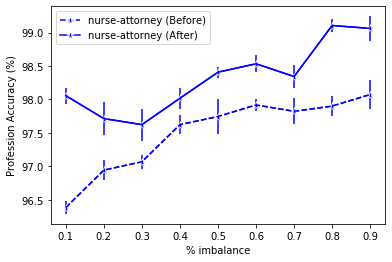

In [13]:
# os.mkdir("tpr-2d")
# os.mkdir("acc-2d")

import matplotlib.pyplot as plt
keys = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = ["blue"] * len(keys)

i=0
#for prof,color in zip(["nurse-physician"], colors): #zip(tpr_before_means.keys(),colors):
for prof,color in zip(tpr_before_means.keys(),colors):
    plt.clf()
    plt.figure()
    stds_before = [tpr_before_stds[prof][k] for k in keys]
    values = [tpr_before_means[prof][k] for k in keys] #list(tpr_before_means[prof].values())
    
    ax = sn.lineplot(keys, values, label=prof+" (Before)", marker="*", markersize=8, linestyle="--",color=color, ci=stds_before)
    #plt.errorbar(keys, values, stds_before, color=color, linestyle="--")
    
    stds_after = [tpr_after_stds[prof][k] for k in keys]
    values = [tpr_after_means[prof][k] for k in keys]
    sn.lineplot(keys, values, label=prof+" (After)", marker="*", markersize=8,color=color)
    plt.errorbar(keys, values, stds_after, color=color)
    ax.set(ylabel="TPR-Gap (%)", xlabel="% imbalance")
    plt.savefig("tpr-imbalanced/{}-per-class.pdf".format(prof), dpi=500)
    
    
    
    plt.clf()
    plt.figure()
    stds_before = [score_before_stds[prof][k] for k in keys]
    values = [score_before_means[prof][k] for k in keys]
    ax = sn.lineplot(keys, values, label=prof+" (Before)", marker="*", markersize=8, linestyle="--",color=color, ci=stds_before)
    plt.errorbar(keys, values, stds_before, color=color, linestyle="--")
    
    stds_after = [score_after_stds[prof][k] for k in keys]
    values =[score_after_means[prof][k] for k in keys]
    sn.lineplot(keys, values, label=prof+" (After)", marker="*", markersize=8,color=color)
    plt.errorbar(keys, values, stds_after, color=color)
    ax.set(ylabel="Profession Accuracy (%)", xlabel="% imbalance")
    plt.savefig("acc-imbalanced/{}-per-class.pdf".format(prof), dpi=500)

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

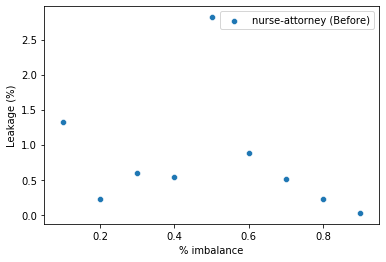

In [14]:
import matplotlib.pyplot as plt
keys = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = ["blue"] * len(keys)

i=0
#for prof,color in zip(["nurse-physician"], colors): #zip(tpr_before_means.keys(),colors):
for prof,color in zip(tpr_before_means.keys(),colors):
    plt.clf()
    plt.figure()
    leakage_vals = [leakage[prof][k] for k in keys]
    
    ax = sn.scatterplot(keys, leakage_vals, label=prof+" (Before)")
    #plt.errorbar(keys, values, stds_before, color=color, linestyle="--")
    ax.set(ylabel="Leakage (%)", xlabel="% imbalance")
    plt.savefig("leakage-imbalanced/{}-per-class.pdf".format(prof), dpi=500)


In [ ]:
os.mkdir("leakage")

In [574]:
score_before_stds

defaultdict(dict,
            {'nurse-physician': {0.15: 0.18479857547842812,
              0.25: 0.24622844001003066,
              0.1: 0.2818400140376761,
              0.2: 0.1536864279849887,
              0.3: 0.21420796244975882,
              0.4: 0.19509491551087416,
              0.5: 0.2015429321530295},
             'journalist-attorney': {0.15: 0.054557535068697,
              0.25: 0.03114287740279736,
              0.1: 0.04863101305271159,
              0.2: 0.015912875024709543,
              0.3: 0.028749729888313823,
              0.4: 0.0253967182768991,
              0.5: 0.012556473577491295},
             'physician-professor': {0.15: 0.031428571428571646,
              0.25: 0.03843892584878293,
              0.1: 0.0371428571428561,
              0.2: 0.020503857277725628,
              0.3: 0.02976095236571489,
              0.4: 0.05256676997992862,
              0.5: 0.026496052844273685},
             'nurse-attorney': {0.15: 0.06718097738434316,
          

In [540]:
with open("projs2/{}-{}-prop={}.pickle".format("nurse","physician", 0.1), "rb") as f:
            data = pickle.load(f)
            x_train_binary, train_profs_binary, train_gender_binary = data["train"]["x"], data["train"]["profs"], data["train"]["gender"]
            x_dev_binary, dev_profs_binary, dev_gender_binary = data["dev"]["x"], data["dev"]["profs"], data["dev"]["gender"]
            output = data["output"]

clf = SGDClassifier() #init_classifier()
clf.fit(x_train_binary, train_profs_binary)
tpr_before=eval_tpr_rms(clf, x_train_binary, train_gender_binary, train_profs_binary)
score_before=clf.score(x_train_binary, train_profs_binary)

In [541]:
score_before

0.9466608846487424

In [581]:
prof2frac2acc = defaultdict(dict)
for (prof1, prof2) in [("nurse", "physician"), ("journalist", "attorney"), ("physician", "professor")]:
    for frac in [0.1, 0.2, 0.3, 0.4, 0.5]:
        
        with open("projs2/{}-{}-prop={}.pickle".format(prof1, prof2, frac), "rb") as f:
            data = pickle.load(f)
            x_train_binary, train_profs_binary, train_gender_binary = data["train"]["x"], data["train"]["profs"], data["train"]["gender"]
            x_dev_binary, dev_profs_binary, dev_gender_binary = data["dev"]["x"], data["dev"]["profs"], data["dev"]["gender"]
            output = data["output"]
            
        x_train_binary_projected = x_train_binary.copy()
            
        x_train_prof = x_train_binary[train_profs_binary==prof1]
        y_train_prof = train_gender_binary[train_profs_binary==prof1]

        output = solve_adv_game(x_train_prof, y_train_prof, x_train_prof, y_train_prof, rank=rank, device="cuda:1", out_iters=num_iters, optimizer_class=optimizer_class, optimizer_params_P =optimizer_params_P, optimizer_params_predictor=optimizer_params_predictor, epsilon=epsilon,batch_size=batch_size)
        P = output["P"]
        clf = init_classifier()
        clf.fit(x_train_prof@P, y_train_prof)
        prof2frac2acc[prof1][frac] = clf.score(x_train_prof@P, y_train_prof)

11000/60000. Acc post-projection: 90.026%; best so-far: 90.026%; Maj: 90.026%; Gap: 0.000%; best loss so far: 0.316:  18%|#8        | 11000/60000 [01:05<04:52, 167.72it/s]
7000/60000. Acc post-projection: 80.052%; best so-far: 80.052%; Maj: 80.052%; Gap: 0.000%; best loss so far: 0.494:  12%|#1        | 7000/60000 [00:43<05:32, 159.18it/s] 
7000/60000. Acc post-projection: 70.078%; best so-far: 70.078%; Maj: 70.078%; Gap: 0.000%; best loss so far: 0.611:  12%|#1        | 7000/60000 [00:44<05:38, 156.58it/s] 
8000/60000. Acc post-projection: 60.017%; best so-far: 60.017%; Maj: 60.017%; Gap: 0.000%; best loss so far: 0.686:  13%|#3        | 8000/60000 [00:51<05:35, 154.93it/s] 
59000/60000. Acc post-projection: 51.605%; best so-far: 50.304%; Maj: 50.043%; Gap: 0.260%; best loss so far: 0.709: 100%|##########| 60000/60000 [06:43<00:00, 148.56it/s]
1000/60000. Acc post-projection: 99.320%; best so-far: 99.320%; Maj: 90.000%; Gap: 9.320%; best loss so far: 0.020:   3%|3         | 2000/60000

KeyboardInterrupt: 

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


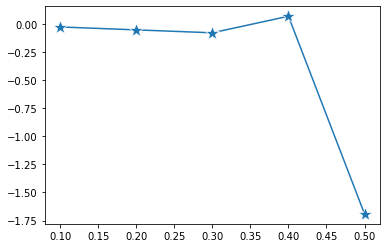

In [589]:
keys = [0.1, 0.2, 0.3, 0.4, 0.5]
vals = [max(100*k, 100-100*k) - prof2frac2acc["nurse"][k]*100 for k in keys]
sn.lineplot(keys, vals, marker="*", markersize=15)
ax.set(ylabel="Gender leakage (%)", xlabel="% imbalance")
#os.mkdir("acc-gender")
plt.savefig("acc-gender/{}-per-class.pdf".format("nurse"), dpi=500)